# 原版的run_model

与run_model_final区别仅在于划分数据集的方式


In [ ]:
# import
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import utils

In [ ]:
# 加载数据
data_arr = utils.load_data(
    "../data/arrays", mask=False
)
nodataval = 0   # 你定义了一个“缺失值填充值” = 0
data_arr = np.where(np.isnan(data_arr), nodataval, data_arr)  # 将数据中的NaN替换为0

Loading variables: ['ndvi', 'sm_30cm_mean', 'RAIN_sum', 'irrig_mm_sum', 'IRRAD_sum', 'TMIN_mean', 'TMAX_mean', 'VAP_mean', 'WIND_mean']
ndvi stats:
 - Mean: 0.6202584
 - Std: 0.2126209
 - Min: 0.30207366
 - Max: 0.95584416
sm_30cm_mean stats:
 - Mean: 25.592056
 - Std: 1.9488047
 - Min: 22.266981
 - Max: 28.896538
RAIN_sum stats:
 - Mean: 6.2400007
 - Std: 10.17536
 - Min: 0.0
 - Max: 43.43
irrig_mm_sum stats:
 - Mean: 2.6147704
 - Std: 7.5484
 - Min: 0.0
 - Max: 30.0
IRRAD_sum stats:
 - Mean: 61729.73
 - Std: 14279.029
 - Min: 13110.0
 - Max: 86300.0
TMIN_mean stats:
 - Mean: 12.134594
 - Std: 2.9194298
 - Min: 5.23
 - Max: 17.506666
TMAX_mean stats:
 - Mean: 24.711082
 - Std: 3.9099383
 - Min: 17.663334
 - Max: 34.386665
VAP_mean stats:
 - Mean: 1.4465002
 - Std: 0.28246108
 - Min: 0.88630325
 - Max: 2.046529
WIND_mean stats:
 - Mean: 7.1424327
 - Std: 1.8819456
 - Min: 3.6966667
 - Max: 11.446667
Data loaded with shape: (37, 49, 76, 9)


In [ ]:
inputs_all = data_arr  # 输入数据包含所有通道
outputs_all = data_arr[:, :, :, 0]  # 输出数据仅包含第一个通道（NDVI）
(
    inputs_train,
    outputs_train,
    inputs_val,
    outputs_val,
    inputs_test,
    outputs_test,
) = utils.normalize_and_split_data(inputs_all, outputs_all)   # 数据归一化和划分训练/验证/测试集

Input train shape: (21, 49, 76, 9)
Output train shape: (21, 49, 76, 1)
Input val shape: (6, 49, 76, 9)
Output val shape: (6, 49, 76, 1)
Input test shape: (7, 49, 76, 9)
Output test shape: (7, 49, 76, 1)


你现在的模型在做的是：

训练阶段：
用 第 0–20 天的数据 → 学会预测 第 1–21 天的 NDVI

验证阶段：
用 第 22–27 天的数据 → 验证预测 第 23–28 天

测试阶段：
用 第 29–35 天的数据 → 测试预测 第 30–36 天

In [12]:
model = utils.build_model(inputs_train)

lr = 2e-4  # 从 0.002 降到 0.0002

try:
    # TF 2.11+ 通常有 AdamW
    opt = keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
except:
    opt = keras.optimizers.Adam(learning_rate=lr)
    
model.compile(
    loss="mean_squared_error",   # 使用均方误差作为损失函数
    optimizer=opt,   # 使用Adam优化器，学习率
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 49, 76,   │             0 │
│                                 │ 9)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 49, 76,   │        47,360 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, None, 49, 76,   │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, None, 49, 76,   │         1,729 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,529 (1.03 MB)

 Trainable params: 270,529 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)   # 验证集 loss 连续 10 个 epoch 不变好就停止训练
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,              # 让它多看一会
    min_delta=1e-4,           # 小于这个改善不算改善，避免抖动骗停
    restore_best_weights=True # 停的时候回到最好的那一轮
)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)   # 验证集 loss 连续 5 个 epoch 不变好就降低学习率
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)
callbacks = [early_stopping, reduce_lr]

# Epochs
epochs = 100

# Fit the model
training_data = model.fit(
    np.expand_dims(inputs_train, 0),
    np.expand_dims(outputs_train, 0),
    epochs=epochs,
    batch_size=1,
    validation_data=(np.expand_dims(inputs_val, 0), np.expand_dims(outputs_val, 0)),
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0954 - val_loss: 0.0485 - learning_rate: 2.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - loss: 0.0837 - val_loss: 0.0483 - learning_rate: 2.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - loss: 0.0729 - val_loss: 0.0482 - learning_rate: 2.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step - loss: 0.0622 - val_loss: 0.0482 - learning_rate: 2.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step - loss: 0.0528 - val_loss: 0.0483 - learning_rate: 2.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - loss: 0.0460 - val_loss: 0.0486 - learning_rate: 2.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - loss: 0.0432 - val_loss: 0.0489 - learning_rate: 2.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step - loss: 0.0431 - val_loss: 0.0493 - learning_rate: 2.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - loss: 0.0436 - val_loss: 0.0496 - learning_rat

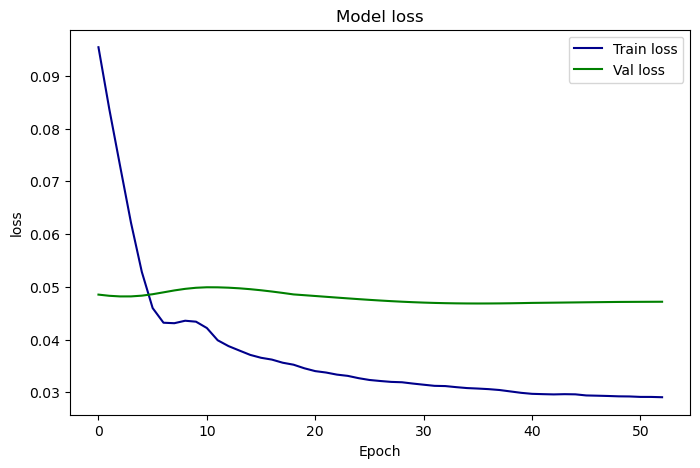

In [14]:
metrics = ["loss"]   # 画 loss 曲线

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(training_data.history[metric], c="darkblue", label=f"Train {metric}")
    plt.plot(training_data.history[f"val_{metric}"], c="green", label=f"Val {metric}")

    plt.title(f"Model {metric}")
    plt.ylabel(metric)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:
score = model.evaluate(  # 对 test 集做一次 loss 评估
    np.expand_dims(inputs_test, 0),
    np.expand_dims(outputs_test, 0),
    batch_size=1,
)
predictions = model.predict(np.expand_dims(inputs_test, 0))    # 对 test 集做预测

np.save("test_arrays", predictions)
print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - loss: 0.0352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
0.03522368147969246


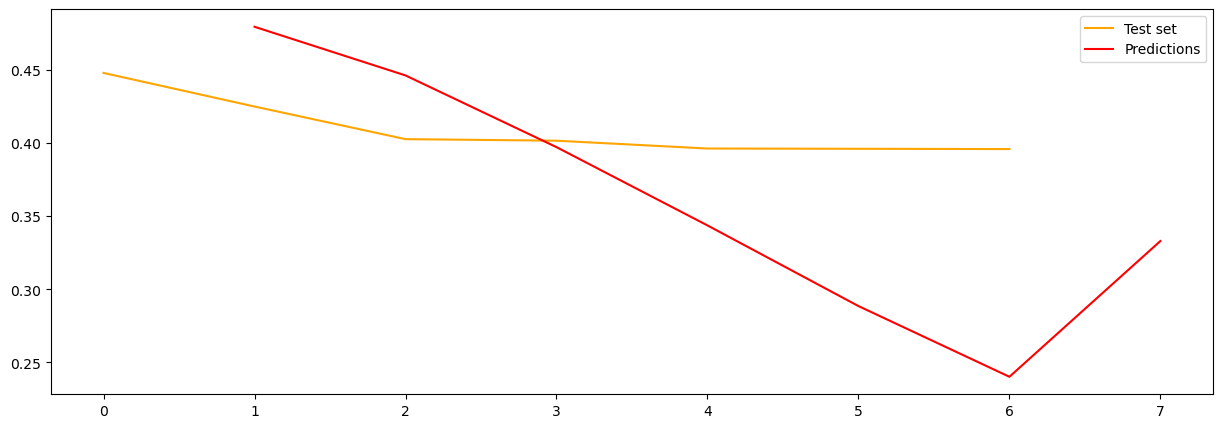

In [ ]:
# 把整张 NDVI 图压缩成时间序列再画图
fig, ax = plt.subplots(figsize=(15, 5))

existing_y = np.nanmean(
    np.reshape(
        outputs_test,
        (outputs_test.shape[0], outputs_test.shape[1] * outputs_test.shape[2]),
    ),
    axis=1,
)
existing_x = np.array(range(len(existing_y)))
later_x = existing_x + 1
found_y = np.nanmean(
    np.reshape(
        predictions[0],
        (predictions.shape[1], predictions.shape[2] * predictions.shape[3]),
    ),
    axis=1,
)

plt.plot(existing_x, existing_y, c="orange", label="Test set")
plt.plot(later_x, found_y, c="red", label="Predictions")
plt.legend()
plt.show()

画最后一帧真实 NDVI vs 最后一帧预测 NDVI

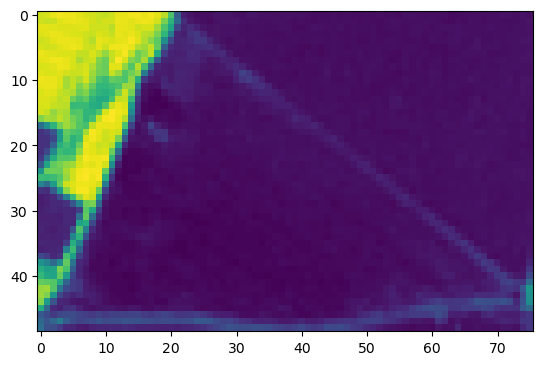

In [ ]:
# Last NDVI timestep before the prediction
plt.imshow(outputs_test[-1, :, :, 0])   # 取 test 集最后一个时间步的真实 NDVI 图

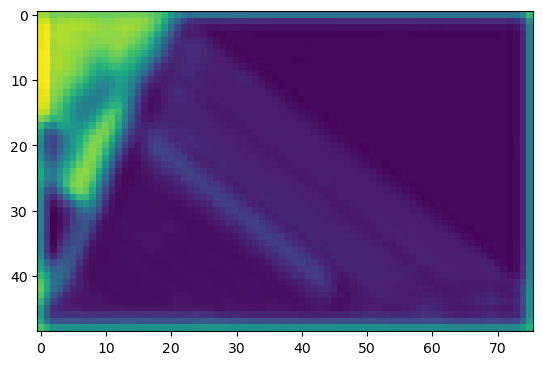

In [10]:
# Prediction
plt.imshow(predictions[0, -1, :, :, 0])

In [11]:
# RMSE of the prediction
rmse = np.sqrt(
    mean_squared_error(outputs_test[-1, :, :, 0], predictions[0, -1, :, :, 0])
)
rmse

np.float64(0.1303561412794731)